In [3]:
import sys
sys.path.append('/home/a202192010/2024/Paper_brain_tumor/models') # put the path to models folder

print(sys.path)

['/home/a202192010/2024/Paper_brain_tumor', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/a202192010/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/lib/python3/dist-packages', '/home/a202192010/2024/Paper_brain_tumor/models']


In [4]:
import tensorflow as tf
import os
import numpy as np

np.set_printoptions(threshold=np.inf) # NumPy 설정
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # CUDA 가시성 설정 (GPU 사용시 필요)

# GPU 메모리 구성 설정 (GPU 사용시 필요)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x에서는 set_memory_growth 대신에 메모리 할당 옵션을 설정하는 코드
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

2024-05-26 13:47:39.958212: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-26 13:47:40.053361: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-26 13:47:41.791868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### data_load

train_images : (3906, 240, 240, 4)
train_labels : (3906, 240, 240)
val_images   : (1302, 240, 240, 4)
val_labels   : (1302, 240, 240)
test_images  : (1302, 240, 240, 4)
test_labels  : (1302, 240, 240)


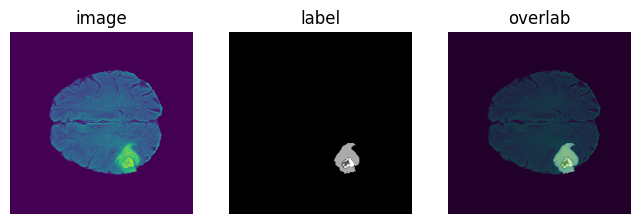

In [29]:
from dataloader import DataProcessor

# 데이터 경로 설정
train_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'
val_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'
test_path = '/home/a202192010/2024/Paper_brain_tumor/dataset/basedata/'

# DataProcessor 클래스 인스턴스 생성
data_processor = DataProcessor(train_path, val_path, test_path)

# 데이터 로드 및 처리
data_processor.load_and_process_data()

# 데이터셋의 크기 출력
data_processor.print_shapes()

# 첫 번째 테스트 이미지 시각화
data_processor.visualize_image(num=0)

In [30]:
train_images = data_processor.train_images
train_labels = data_processor.train_labels
val_images = data_processor.val_images
val_labels = data_processor.val_labels
test_images = data_processor.test_images
test_labels = data_processor.test_labels

### 데이터 샘플링

In [33]:
def sample_data(images, labels, fraction):
    _, sampled_images, _, sampled_labels = train_test_split(images, labels, test_size=fraction, random_state=42)
    return sampled_images, sampled_labels

In [35]:
import numpy as np
from sklearn.model_selection import train_test_split

## this one for the make the fit more faster

fraction = 0.4
train_images, train_labels = sample_data(data_processor.train_images, data_processor.train_labels, fraction)
val_images, val_labels = sample_data(data_processor.val_images, data_processor.val_labels, fraction)
test_images, test_labels = sample_data(data_processor.test_images, data_processor.test_labels, fraction)


In [36]:
print(f"Train images shape: {train_images.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Validation images shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")


Train images shape: (1563, 240, 240, 4)
Train labels shape: (1563, 240, 240)
Validation images shape: (521, 240, 240, 4)
Validation labels shape: (521, 240, 240)
Test images shape: (521, 240, 240, 4)
Test labels shape: (521, 240, 240)


### categorical-label

In [37]:
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(train_labels, num_classes=4) # 레이블 원핫 인코딩
val_labels = to_categorical(val_labels, num_classes=4)

### model

In [40]:
from unet3plus_3cnn_dilation_nobridge import f_model ## model

input_shape = (240, 240, 4) # change channel by the shape of dataset
num_classes = 4
model = f_model(input_shape, num_classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 240, 240, 4)]        0         []                            
                                                                                                  
 conv2d_66 (Conv2D)          (None, 240, 240, 64)         2368      ['input_layer[0][0]']         
                                                                                                  
 batch_normalization_64 (Ba  (None, 240, 240, 64)         256       ['conv2d_66[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_66 (Activation)  (None, 240, 240, 64)         0         ['batch_normalization_64

 max_pooling2d_22 (MaxPooli  (None, 30, 30, 256)          0         ['activation_74[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 conv2d_75 (Conv2D)          (None, 30, 30, 512)          1180160   ['max_pooling2d_22[0][0]']    
                                                                                                  
 batch_normalization_73 (Ba  (None, 30, 30, 512)          2048      ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_75 (Activation)  (None, 30, 30, 512)          0         ['batch_normalization_73[0][0]
                                                                    ']                            
          

                                                                                                  
 max_pooling2d_28 (MaxPooli  (None, 60, 60, 128)          0         ['activation_71[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 up_sampling2d_12 (UpSampli  (None, 60, 60, 256)          0         ['activation_82[0][0]']       
 ng2D)                                                                                            
                                                                                                  
 conv2d_83 (Conv2D)          (None, 60, 60, 64)           36928     ['max_pooling2d_27[0][0]']    
                                                                                                  
 conv2d_84 (Conv2D)          (None, 60, 60, 64)           73792     ['max_pooling2d_28[0][0]']    
          

                                                                                                  
 activation_89 (Activation)  (None, 120, 120, 64)         0         ['batch_normalization_87[0][0]
                                                                    ']                            
                                                                                                  
 activation_90 (Activation)  (None, 120, 120, 64)         0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 120, 120, 64)         0         ['batch_normalization_89[0][0]
                                                                    ']                            
                                                                                                  
 concatena

__________________________________________________________________________________________________


### fit

In [41]:
from loss import bce_dice_loss

histories = []
model_paths = {}

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy'])
history= model.fit(train_images, train_labels, epochs=50, batch_size=32, validation_data=(val_images, val_labels))
histories.append(history.history)

Epoch 1/50
49/49 [==============================] - 105s 1s/step - loss: 0.2206 - accuracy: 0.9670 - val_loss: 1.7589 - val_accuracy: 0.3375
Epoch 2/50
49/49 [==============================] - 29s 583ms/step - loss: 0.0454 - accuracy: 0.9885 - val_loss: 0.3373 - val_accuracy: 0.9817
Epoch 3/50
49/49 [==============================] - 28s 583ms/step - loss: 0.0307 - accuracy: 0.9911 - val_loss: 0.3748 - val_accuracy: 0.9886
Epoch 4/50
49/49 [==============================] - 28s 582ms/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.0532 - val_accuracy: 0.9880
Epoch 5/50
49/49 [==============================] - 28s 582ms/step - loss: 0.0237 - accuracy: 0.9923 - val_loss: 0.0344 - val_accuracy: 0.9886
Epoch 6/50
49/49 [==============================] - 29s 583ms/step - loss: 0.0200 - accuracy: 0.9933 - val_loss: 0.0249 - val_accuracy: 0.9920
Epoch 7/50
49/49 [==============================] - 29s 584ms/step - loss: 0.0188 - accuracy: 0.9936 - val_loss: 0.0256 - val_accuracy: 0.9909
E

2024-05-26 16:22:22.986681: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-26 16:22:22.987263: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


49/49 [==============================] - 29s 589ms/step - loss: 0.0083 - accuracy: 0.9968 - val_loss: 0.0108 - val_accuracy: 0.9959
Epoch 47/50
49/49 [==============================] - 29s 584ms/step - loss: 0.0081 - accuracy: 0.9969 - val_loss: 0.0098 - val_accuracy: 0.9962
Epoch 48/50
49/49 [==============================] - 29s 586ms/step - loss: 0.0083 - accuracy: 0.9968 - val_loss: 0.0105 - val_accuracy: 0.9961
Epoch 49/50
49/49 [==============================] - 29s 586ms/step - loss: 0.0090 - accuracy: 0.9965 - val_loss: 0.0119 - val_accuracy: 0.9956
Epoch 50/50
49/49 [==============================] - 30s 608ms/step - loss: 0.0085 - accuracy: 0.9967 - val_loss: 0.0120 - val_accuracy: 0.9954


#### test data evaluate

In [42]:
test_label_e = to_categorical(test_labels, num_classes=4)
loss, acc = model.evaluate(test_images, test_label_e, verbose=2)

17/17 - 3s - loss: 0.0123 - accuracy: 0.9953 - 3s/epoch - 151ms/step


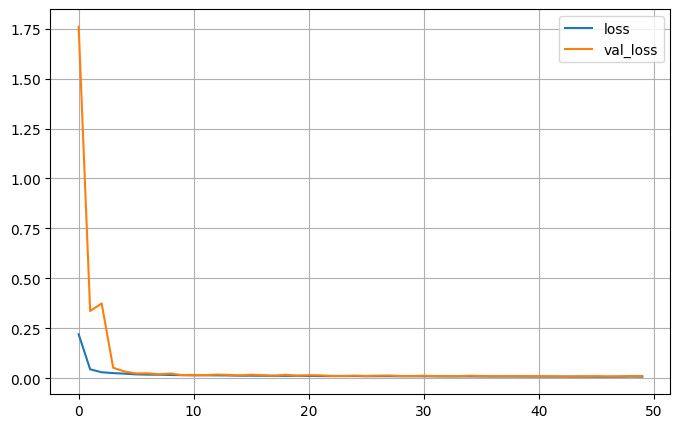

(<matplotlib.legend.Legend at 0x7f033c85e7f0>, None, None)

In [43]:
import matplotlib.pyplot as plt

plot_target = ['loss', 'val_loss']
plt.figure(figsize=(8,5))
for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.legend(), plt.grid(), plt.show()

In [44]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = model.predict(test_images)

y_true = np.argmax(test_label_e, axis=3)
y_pred = np.argmax(y_pred, axis=3)

y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()

conf_mat = confusion_matrix(y_true_flat, y_pred_flat)

17/17 [==============================] - 4s 142ms/step


### results

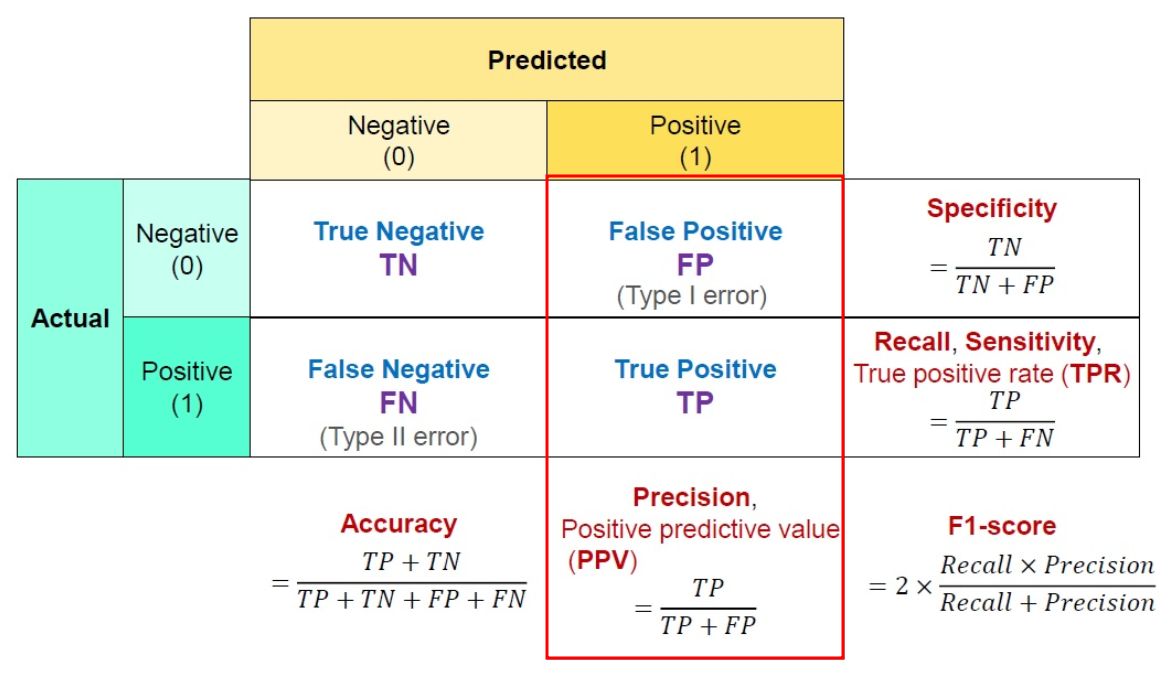

In [47]:
import pandas as pd
from metrix import sensitivity,specificity,F1_score,precision

Sensitivity = sensitivity(conf_mat, 4)
Specificity = specificity(conf_mat, 4)
f1 = F1_score(conf_mat, 4)
Positive_predictive_value = precision(conf_mat, 4)

data = {'Sensitivity': Sensitivity,
        'Specificity': Specificity,
        'F1 Score': f1,
        'Precision': Positive_predictive_value}

df = pd.DataFrame(data, index=[0,1,2,3])
df.loc['Col Ave'] = df.mean()

df

,Sensitivity,Specificity,F1 Score,Precision
0,0.997500,0.9481,0.99820,0.998900
1,0.769800,0.9998,0.83100,0.902700
2,0.932100,0.9969,0.86740,0.811000
3,0.842100,0.9996,0.86800,0.895500
Col Ave,0.885375,0.9861,0.89115,0.902025


1 )
1/1 [==============================] - 1s 1s/step
mismatched labels: 93


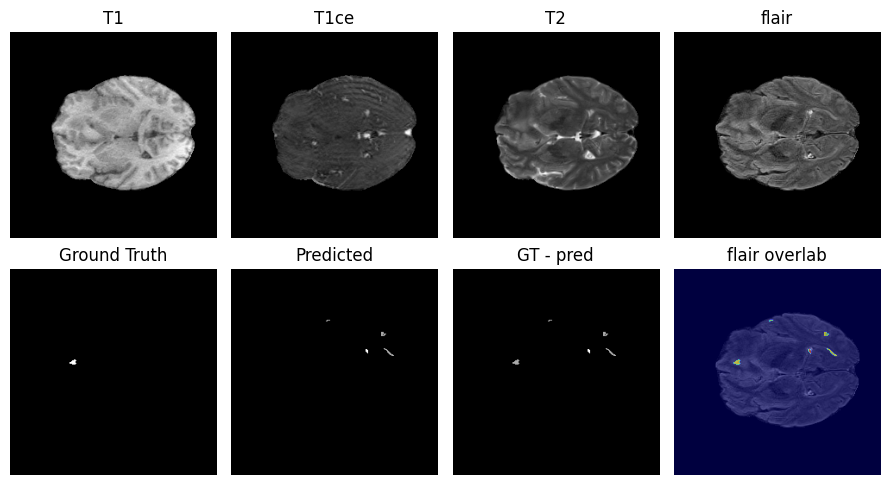

2 )
1/1 [==============================] - 0s 52ms/step
mismatched labels: 210


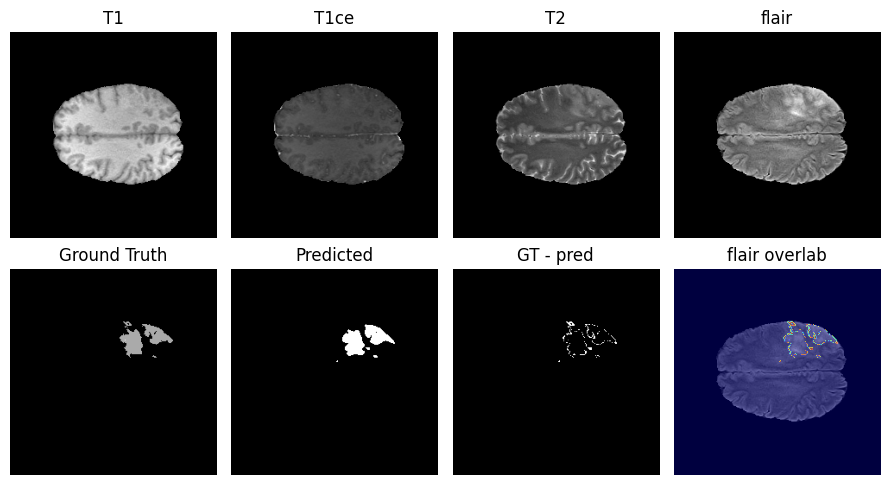

3 )
1/1 [==============================] - 0s 61ms/step
mismatched labels: 228


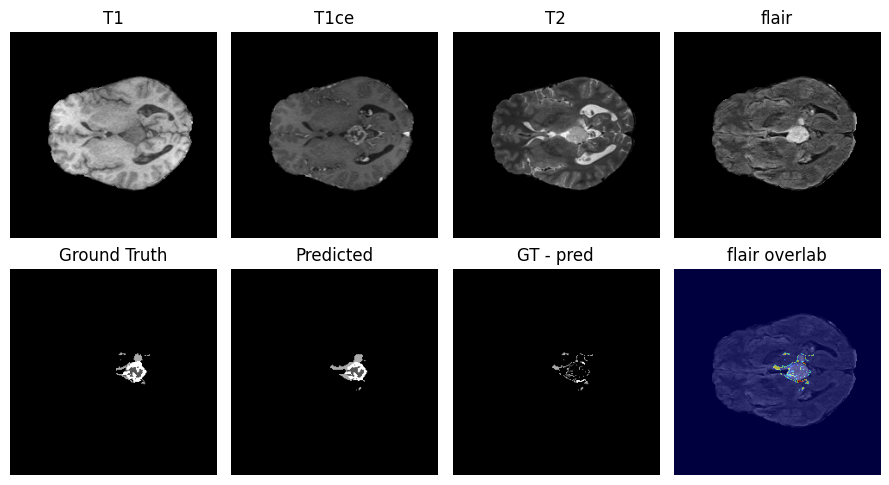

4 )
1/1 [==============================] - 0s 52ms/step
mismatched labels: 167


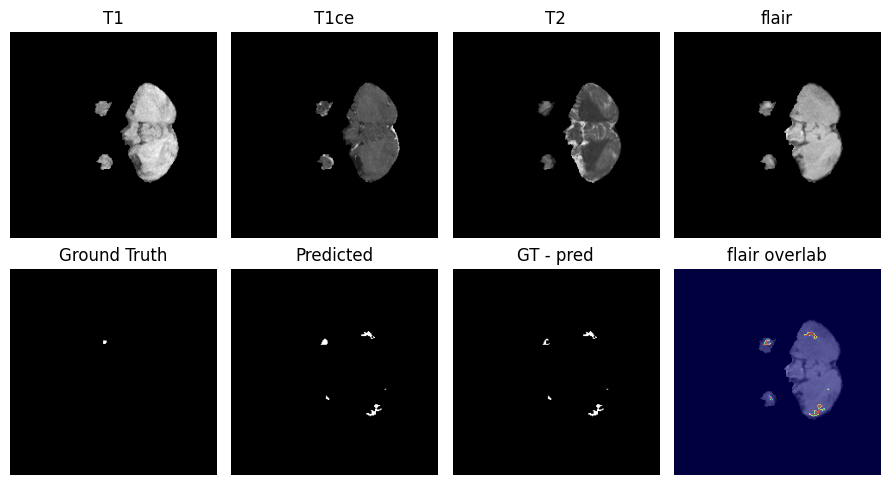

5 )
1/1 [==============================] - 0s 57ms/step
mismatched labels: 254


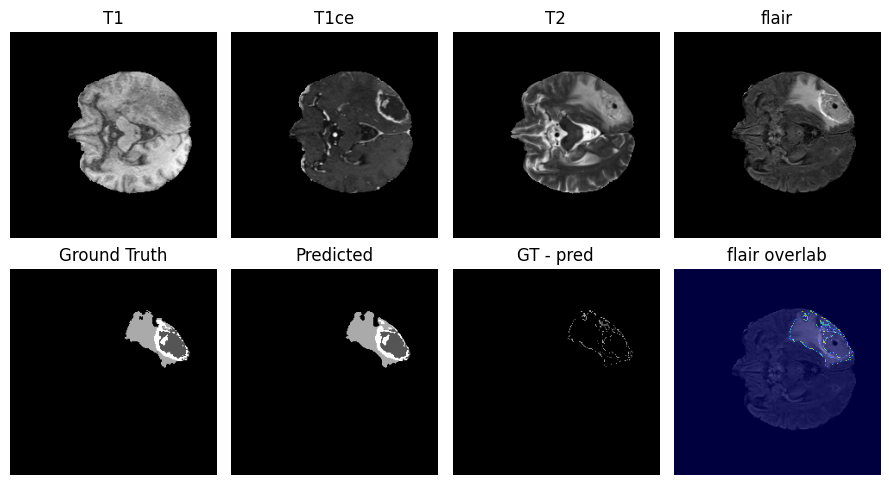

In [48]:
from testvisual import visual_num

for i in range(5):
    print(i + 1, ")")
    visual_num(i, test_images, test_labels, model)

In [ ]:
model.save('brain_tumor_base.h5')